┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_Mpmty7Adg5\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_q3EHW5i5mT\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_8FCTQ1kLcD\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_utKBA3sb4n\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzS

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    19204
Number of nonzeros in inequality constraint Jacobian.:     3204
Number of nonzeros in Lagrangian Hessian.............:    18406

Total number of variables............................:     4804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2403
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3204
Total number of inequality constraints...............:     2403
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1602
        inequality constraints with only upper bounds:      801

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 1.00e-01 8.06e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_gPejmjcrsT\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_KNqvoH2dON\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


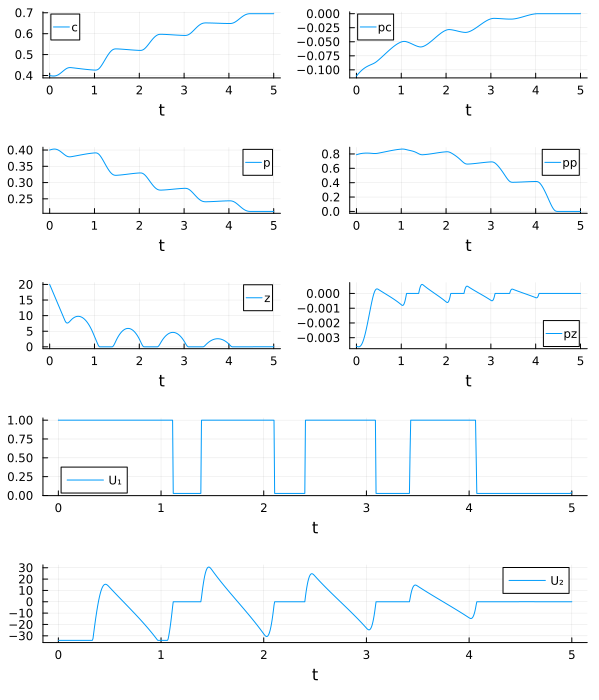

In [21]:
using OptimalControl
using NLPModelsIpopt
using Plots
using MadNLP

# ------------------ Parameters ------------------
kP = 1.6
K = 140.0
I_max = 300.0       # 最大光照强度
α = 0.1
L = 50.0            # 水体深度上限
kR_bar = 1.5
z_bar = 35.0
n = 1
tf = 5.0            # 时间区间（天）
ϵ = 1e-5
# ------------------ 光照函数（平滑昼夜变化） ------------------
function I_light_surface(t)
    return I_max * (max(0, sin(2π * t)))^2
end

function I_light(z, t)
    return I_light_surface(t) * exp(-α * z)
end

# ------------------ 生物学函数 ------------------
function vP(p, z, t)
    return kP * p * I_light(z, t) / (K + p * I_light(z, t))
end

function kR(z)
    return kR_bar * z^n / (z_bar^n + z^n)
end

# ------------------ 最优控制问题定义 ------------------
ocp = @def begin
    t ∈ [0, tf], time
    x = (c, p, z) ∈ R^3, state
    U ∈ R^2, control

    c(0) == 0.4
    p(0) == 0.4
    z(0) == 20.0

    0 ≤ U(t)[1] ≤ 1
    -34 ≤ U(t)[2] ≤ 34     # 垂直速度控制上限，单位 m/d

    0 ≤ c(t) ≤ 1
    0 ≤ p(t) ≤ 1
    0 ≤ z(t) ≤ L
    c(t) + p(t) ≤ 1

    ẋ(t) == [
        vP(p(t), z(t), t) * (1 - c(t)) - kR(z(t)) * c(t) * (1 - c(t) - p(t)),
        U(t)[1] * kR(z(t)) * c(t) * (1 - c(t) - p(t)) - vP(p(t), z(t), t) * p(t),
        U(t)[2]
    ]

    ∫(vP(p(t), z(t), t) - ϵ * (U(t)[1]^2 + U(t)[2]^2)) → max
end

# ------------------ 逐步求解策略 ------------------
sol1 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, grid_size = 50, display = false)
sol2 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, init = sol1, grid_size = 100, display = false)
sol3 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, init = sol2, grid_size = 200, display = false)
sol4 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol3, grid_size = 300, display = false)
sol5 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol4, grid_size = 400, display = false)
sol6 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol5, grid_size = 500, display = false)
sol7 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol6, grid_size = 600, display = false)
sol8 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol7, grid_size = 700, display = false)
sol  = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol8, grid_size = 800, display = true)


# ------------------ 结果可视化 ------------------
plt = plot(sol)
display(plt)


┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_WtGVqBop2H\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_mpe3u78ZYj\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_KDk5AJiD2d\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_CTCVaJah8d\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzS

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:    19204
Number of nonzeros in inequality constraint Jacobian.:     3204
Number of nonzeros in Lagrangian Hessian.............:    18406

Total number of variables............................:     4804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2403
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3204
Total number of inequality constraints...............:     2403
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1602
        inequality constraints with only upper bounds:      801

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 1.00e-01 9.54e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_unsNI3yZqp\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297
┌ Warning: could not parse Ipopt log file. SystemError("opening file \"C:\\\\Users\\\\gouxinyi\\\\AppData\\\\Local\\\\Temp\\\\jl_o9sfA9YjKb\"", 13, nothing)
└ @ NLPModelsIpopt C:\Users\gouxinyi\.julia\packages\NLPModelsIpopt\OGzSv\src\NLPModelsIpopt.jl:297


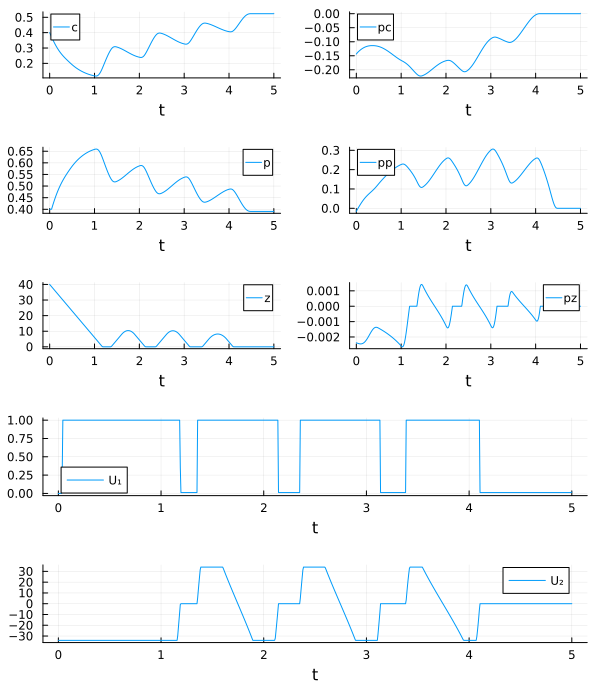

In [ ]:
using OptimalControl
using NLPModelsIpopt
using Plots
using MadNLP

# ------------------ Parameters ------------------
kP = 1.6
K = 140.0
I_max = 300.0       # 最大光照强度
α = 0.1
L = 50.0            # 水体深度上限
kR_bar = 1.5
z_bar = 35.0
n = 1
tf = 5.0            # 时间区间（天）
ϵ = 1e-5
# ------------------ 光照函数（平滑昼夜变化） ------------------
function I_light_surface(t)
    return I_max * (max(0, sin(2π * t)))^2
end

function I_light(z, t)
    return I_light_surface(t) * exp(-α * z)
end

# ------------------ 生物学函数 ------------------
function vP(p, z, t)
    return kP * p * I_light(z, t) / (K + p * I_light(z, t))
end

function kR(z)
    return kR_bar * z^n / (z_bar^n + z^n)
end

# ------------------ 最优控制问题定义 ------------------
ocp = @def begin
    t ∈ [0, tf], time
    x = (c, p, z) ∈ R^3, state
    U ∈ R^2, control

    c(0) == 0.4
    p(0) == 0.4
    z(0) == 40.0

    0 ≤ U(t)[1] ≤ 1
    -34 ≤ U(t)[2] ≤ 34     # 垂直速度控制上限，单位 m/d

    0 ≤ c(t) ≤ 1
    0 ≤ p(t) ≤ 1
    0 ≤ z(t) ≤ L
    c(t) + p(t) ≤ 1

    ẋ(t) == [
        vP(p(t), z(t), t) * (1 - c(t)) - kR(z(t)) * c(t) * (1 - c(t) - p(t)),
        U(t)[1] * kR(z(t)) * c(t) * (1 - c(t) - p(t)) - vP(p(t), z(t), t) * p(t),
        U(t)[2]
    ]

    ∫(vP(p(t), z(t), t) - ϵ * (U(t)[1]^2 + U(t)[2]^2)) → max
end

# ------------------ 逐步求解策略 ------------------
sol1 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, grid_size = 50, display = false)
sol2 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, init = sol1, grid_size = 100, display = false)
sol3 = solve(ocp, :direct, :adnlp, :madnlp; disc_method = :midpoint, init = sol2, grid_size = 200, display = false)
sol4 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol3, grid_size = 300, display = false)
sol5 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol4, grid_size = 400, display = false)
sol6 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol5, grid_size = 500, display = false)
sol7 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol6, grid_size = 600, display = false)
sol8 = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol7, grid_size = 700, display = false)
sol  = solve(ocp, :direct, :adnlp, :ipopt; disc_method = :midpoint, init = sol8, grid_size = 800, display = true)


# ------------------ 结果可视化 ------------------
plt = plot(sol)
display(plt)
